In [1]:
%cd ../../..

/home/eli/AnacondaProjects/surprisal_regression


In [2]:
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
from src.models.components.linear_regression import TrialwiseLinearRegression
import src.eval as evaluation

In [4]:
with hydra.initialize(version_base="1.3", config_path="../../../configs", job_name="eval"):
    cfg = hydra.compose(config_name="eval.yaml", overrides=["ckpt_path=logs/train/runs/2025-03-14_17-26-03/checkpoints/last.ckpt", "data.session_path=/mnt/data/surprisal_coding/epoched/glo_mua_epoched_11.mat",
                        "data.area=MST"], return_hydra_config=True)
    hydra.core.hydra_config.HydraConfig.instance().set_config(cfg)
    _, objects = evaluation.evaluate(cfg)

[rank: 0] No logger configs found! Skipping...
[striatum:3468639] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/3545956352/shared_mem_cuda_pool.striatum could be created.
[striatum:3468639] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at logs/train/runs/2025-03-14_17-26-03/checkpoints/last.ckpt
/home/eli/miniforge3/envs/ephys/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["EarlyStopping{'monitor': 'val/loss', 'mode': 'min'}", "ModelCheckpoint{'monitor': 'val/loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': N

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/log_evidence     │       -872680.6875        │
│         test/loss         │         1709139.5         │
└───────────────────────────┴───────────────────────────┘

In [5]:
objects['model'].importance.angle_alpha

tensor([0.4995, 0.5005], grad_fn=<DivBackward0>)

In [6]:
(objects['model'].importance.repetition_q_loc, objects['model'].importance.repetition_q_log_scale.exp())

(Parameter containing:
 tensor([0.0010], requires_grad=True),
 tensor([1.0008], grad_fn=<ExpBackward0>))

In [7]:
objects['model'].importance.selectivity_q_log_scale.exp()

tensor([1.0003, 1.0010], grad_fn=<ExpBackward0>)

In [8]:
objects['model'].importance.surprise_q_log_scale.exp()

tensor([1.0006, 1.0009, 0.9998, 1.0008], grad_fn=<ExpBackward0>)

In [9]:
with torch.no_grad():
    originals = []
    reconstructions = []
    regressor = []
    
    for b, (muae, regressors) in tqdm(enumerate(objects['datamodule'].test_dataloader())):
        _, predictions, _ = objects['model'].model_step((muae, regressors))
    
        originals.append(muae)
        reconstructions.append(predictions.mean(dim=0))
        regressor.append(regressors)

    originals = torch.cat(originals, dim=0)
    reconstructions = torch.cat(reconstructions, dim=0)
    regressors = torch.cat(regressor, dim=0)

8it [00:00, 16.58it/s]


In [10]:
def lo_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[1, 1, 1, 0.8]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

def go_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[1, 1, 1, 0.2]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

def rndctrl_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[0.5, 0.5, 0.5, 0.5]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

def seqctrl_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[1., 1., 1., 1.]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

In [11]:
def comparison_plot(trials):
    heights = []
    all_originals = originals[trials, :].mean(dim=0)
    all_reconstructions = reconstructions[trials, :].mean(dim=0)

    for p in range(4):
        heights = heights + [all_originals[p].item(), all_reconstructions[p].item()]

    plt.bar(["P1", "P1'", "P2", "P2'", "P3", "P3'", "P4", "P4'"], heights, color=[('b', 1.), ('b', 0.4), ('b', 1.), ('b', 0.4), ('b', 1.), ('b', 0.4), ('b', 1.), ('b', 0.4)])

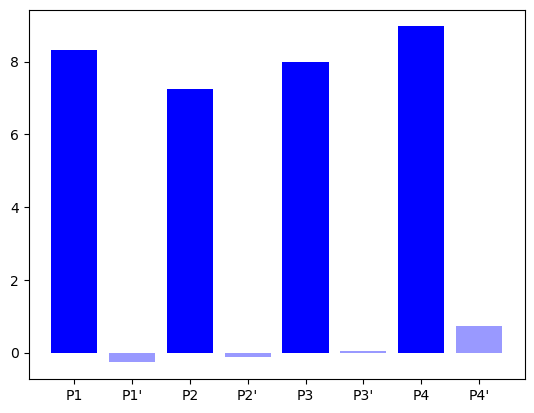

In [12]:
comparison_plot(lo_trials())

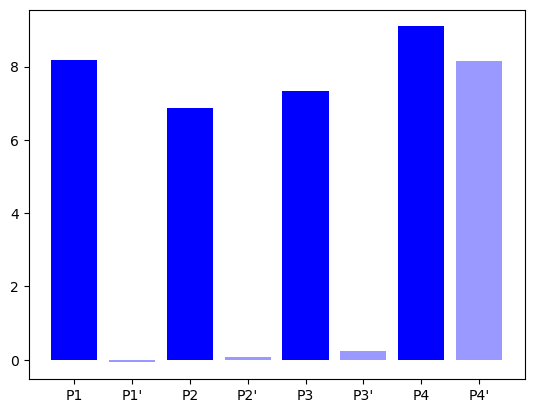

In [13]:
comparison_plot(go_trials())

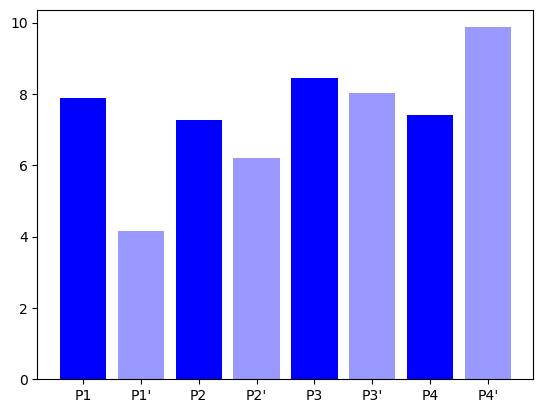

In [14]:
comparison_plot(rndctrl_trials())

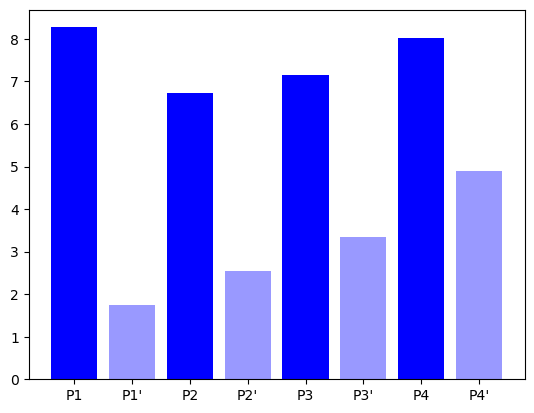

In [15]:
comparison_plot(seqctrl_trials())